## Hello everyone,

#### welcome to this place,

Here is Federico. In this notebook I would like to share the method I used to make "dimensionality reduction" on a TF-IDF sparse Matrix.

It means we are in a NLP task. For this notebook I used the dataset *Toxic Comment Classification Challenge* available on Kaggle. (here:https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In this dataset our input is "just" a text, a comment, and the goal of this competition is to predict six binary outputs simultaneously. In detail *'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'*

One technique to manage text data is TF-IDF (explanation here https://en.wikipedia.org/wiki/Tf%E2%80%93idf). It is quite similar to
BagOfWords in which we build a vector (V x 1), with V the length of the vocabulary, composed by 0s where the words are not present in the text and 1s if they are. Instead, TFIDF *"is intended to reflect how important a word is to a document in a collection or corpus"*

The main problem of this method is that the matrix is huge because of the dimension of the vocabulary. In this case we have a dataset with text generated from comments of users of wikipedia. It means that many mistakes are present. Each of these mistakes generates a new word in the vocabulary. 

In general it is common to considerate only the firsts (not so easy) N words in order to reduce all computations.

Because of the particular composition of this dataset (unbalanced), the **discriminant words** could be somewhat rare. As we can guess, it is not so common to read *"motherfucker"* inside a comment.

This means we should find another way.

Possible solutions:
    
    i) remove each columns (that means words, which means variables) from TF-IDF matrix which present standard deviation less than a threshold.
    ii) dimensionality reduction on TF-IDF matrix
 
I do not like the first solution too much, but it's fast! I don't like the second solution too. I do not want to reduce the TF-IDF matrix into a smaller one that I can manage. I want to hold just the part of the variance which can be useful in discriminating input text in *'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'*.

In [1]:
import pandas as pd
import numpy as np

from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

def clean(x):
    removerPunctuation = str.maketrans({k:' ' for k in punctuation})
    x = x.translate(removerPunctuation)
    return x.lower().strip()

from time import time
from tqdm import tqdm

import multiprocessing as mp
import gc

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (159571, 8)
Test shape:  (153164, 2)


In [3]:
train['comment_text'] = train.comment_text.str.replace("\n","").replace("—","")
test['comment_text'] = test.comment_text.str.replace("\n","").replace("—","")

train['comment_text'] = train.apply(axis=1, func = lambda x: clean(str(x.comment_text)))
test['comment_text'] = test.apply(axis=1, func = lambda x: clean(str(x.comment_text)))

In [4]:
tt = pd.concat([train.comment_text,test.comment_text], axis=0).reset_index(drop=True)

tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words="english", max_features=None)

tfidf_all = tfidf.fit_transform(tt)
train_tfidf = tfidf_all[:train.shape[0]]
test_tfidf = tfidf_all[train.shape[0]:]

del tfidf, tfidf_all, tt
gc.collect()

264

In [5]:
print("The dimension of the vocabulary is quite huge:")
print("V is equal to {}".format(train_tfidf.shape[1]))

The dimension of the vocabulary is quite huge:
V is equal to 368026


The idea behind this notebook is to keep just the columns that are able to discriminate the text. 

My purpose is to keep just the words that have the two marginal distribution different in term of **Kolmogorov-Smirnov**

#### An example:

In [6]:
c ='toxic'
for i in range(0,10000):
    label = pd.DataFrame(train[c].values, columns=['label']).copy()
    tmp = pd.DataFrame(train_tfidf[:,i].todense(), columns=['column'])
    comparison = pd.concat([tmp,label], axis = 1)
    ones = comparison['column'][comparison.label == 1]
    zeros = comparison['column'][comparison.label == 0]
    _, p = ks_2samp(ones, zeros)
        
    if p < 0.2:
        print(i)
        break

5962


In [7]:
i = 5962

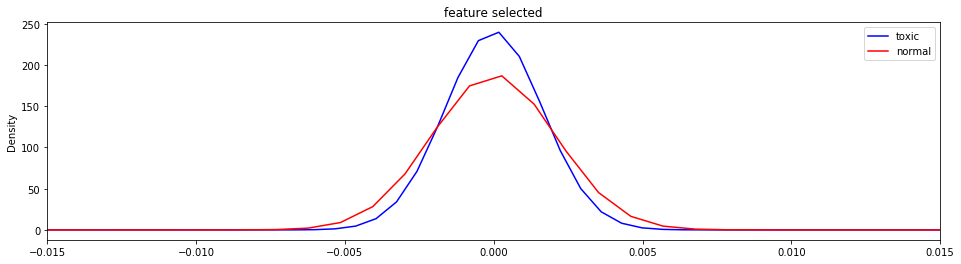

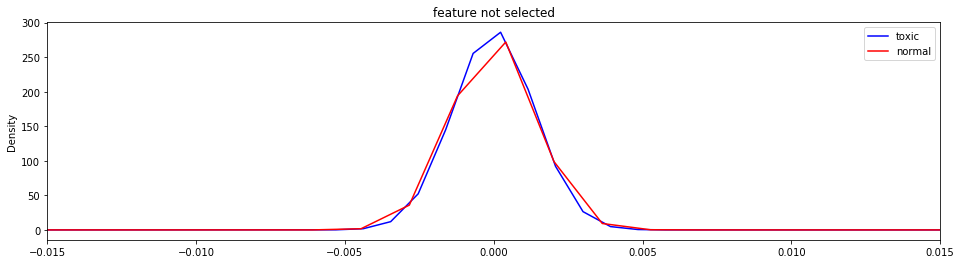

In [8]:
label = pd.DataFrame(train[c].values, columns=['label']).copy()
tmp = pd.DataFrame(train_tfidf[:,i].todense(), columns=['column'])
comparison = pd.concat([tmp,label], axis = 1)
ones = comparison['column'][comparison.label == 1]
zeros = comparison['column'][comparison.label == 0]

plt.figure(figsize=(16,4))
plt.title("feature selected")
ones.plot(kind='density', color="blue", xlim = (-0.015, 0.015))
zeros.plot(kind='density', color="red")
plt.legend(("toxic","normal"))
plt.show()

label = pd.DataFrame(train[c].values, columns=['label']).copy()
tmp = pd.DataFrame(train_tfidf[:,1].todense(), columns=['column'])
comparison = pd.concat([tmp,label], axis = 1)
ones = comparison['column'][comparison.label == 1]
zeros = comparison['column'][comparison.label == 0]

plt.figure(figsize=(16,4))
plt.title("feature not selected")
ones.plot(kind='density', color="blue", xlim = (-0.015, 0.015))
zeros.plot(kind='density', color="red")
plt.legend(("toxic","normal"))
plt.show()

In [ ]:
def function_ks_on_tfidf(i):
    tmp = pd.DataFrame(train_tfidf[:,i].todense(), columns=['column'])
    comparison = pd.concat([tmp,label], axis = 1)
    ones = comparison['column'][comparison.label == 1]
    zeros = comparison['column'][comparison.label == 0]

    _, p = ks_2samp(ones, zeros)
    
    if p < 0.1:
        return i

for c in tqdm(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    x =  time()
    label = pd.DataFrame(train[c].values, columns=['label']).copy()
    
    inputs = range(0,train_tfidf.shape[1])
    
    pool = mp.Pool(processes=4)
    results = pool.map(function_ks_on_tfidf, inputs)
    
    which_cols = list(set(results) - set([None]))
    
    del inputs, results, pool, label
    gc.collect()
    
    # saving
    out_train = pd.DataFrame(train_tfidf[:,which_cols].todense())
    out_train.columns = ["tfidf_" + str(i) for i in out_train.columns]
    
    out_train.to_csv("train_tfidf_"+str(c)+".csv")
    
    del out_train
    gc.collect()
    
    out_test = pd.DataFrame(test_tfidf[:,which_cols].todense())
    out_test.columns = ["tfidf_" + str(i) for i in out_test.columns]
    
    out_test.to_csv("test_tfidf_"+str(c)+".csv")
    
    del out_test, which_cols
    gc.collect()
        
    print(c, "ended...")
    print("It requires:", np.round((time()-x)/60,2), "minutes", end="\n\n")

  0%|          | 0/6 [00:00<?, ?it/s]

### CONCLUSION

##### It is quite slow. On multithread almost 1 hour for each label!


My goal is to share a possible way to extract right features from a TF-IDF matrix in tasks of text classification.

Please leave a feedback about this method. 

See you around,

Federico